In [17]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


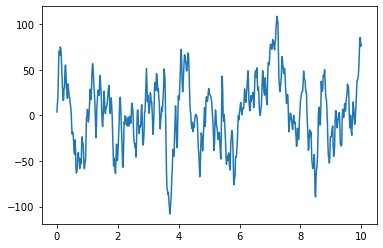

In [18]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [52]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [53]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
#dm.normalize()
print(dm)

X_train: shape of(1387, 31, 640)
X_test: shape of(1487, 31, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(31, 31)
A_test: shape of(31, 31)
P_avg_train: shape of(31, 31)
P_avg_test: shape of(31, 31)
--------data successfully filtered (dvariance)--------
X_train: shape of(1387, 28, 31)
X_test: shape of(1487, 28, 31)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


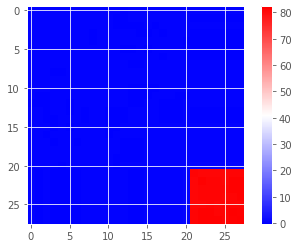

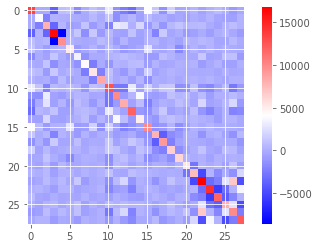

In [54]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

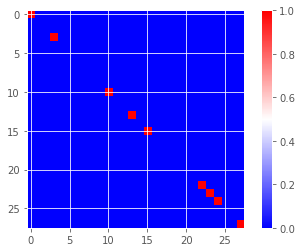

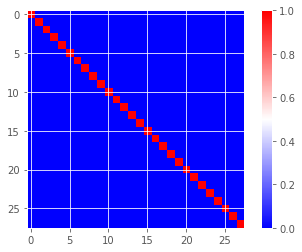

In [55]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

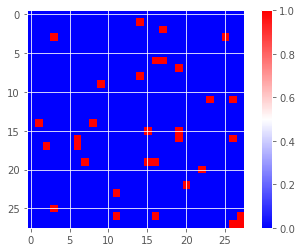

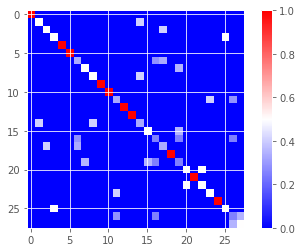

In [56]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

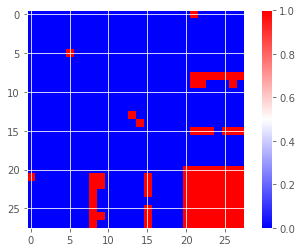

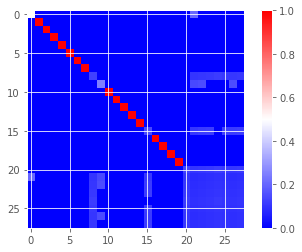

In [57]:
n = 0.1#1.3*10**-2
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [58]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 2,
    'num_epochs': 5,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 1,
    "N": 20,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

  0%|          | 0/6 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 6 of size 256   Train loss: 388.16070556640625   Valid loss: 387.3428649902344
Epoch:

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2   Batch: 6 of size 256   Train loss: 383.25457763671875   Valid loss: 382.9647216796875
Epoch: 3   Batch: 3 of size 256   Train loss: 381.42083740234375   Valid loss: 381.1080322265625

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3   Batch: 6 of size 256   Train loss: 379.5930480957031   Valid loss: 380.09564208984375
Epoch: 4   Batch: 6 of size 256   Train loss: 377.3939208984375   Valid loss: 378.76351928710945
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5   Batch: 6 of size 256   Train loss: 376.1430969238281   Valid loss: 378.48455810546875
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

 18%|█▊        | 2/11 [00:01<00:07,  1.27it/s]

 27%|██▋       | 3/11 [00:02<00:06,  1.29it/s]

 36%|███▋      | 4/11 [00:03<00:05,  1.28it/s]

 45%|████▌     | 5/11 [00:03<00:04,  1.24it/s]

 55%|█████▍    | 6/11 [00:04<00:04,  1.24it/s]

 64%|██████▎   | 7/11 [00:05<00:03,  1.24it/s]

 73%|███████▎  | 8/11 [00:06<00:02,  1.24it/s]

 82%|████████▏ | 9/11 [00:07<00:01,  1.25it/s]

 91%|█████████ | 10/11 [00:07<00:00,  1.26it/s]

100%|██████████| 11/11 [00:08<00:00,  1.27it/s]

Epoch: 1   Batch: 11 of size 128   Train loss: 382.48895263671875   Valid loss: 382.3702087402344
----------Training Ends-----------


Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


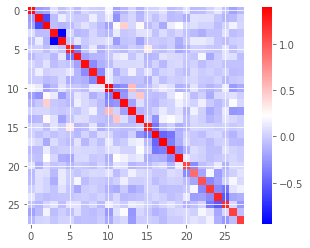

Average Non-Ictal


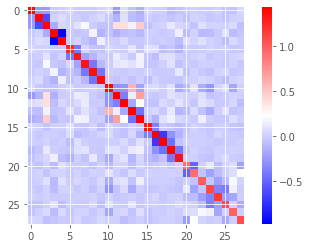

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


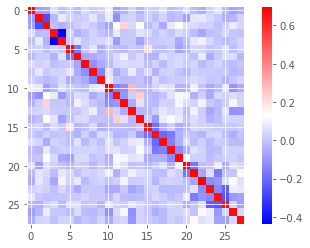

Average Non-Ictal


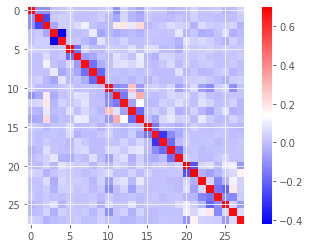

Sample Ictal and Non-Ictal Simularity Matrix for GCN
sample ictal


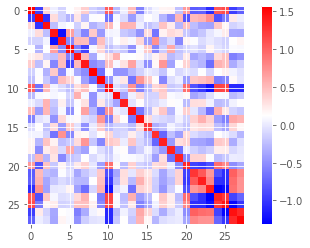

sample Non-Ictal


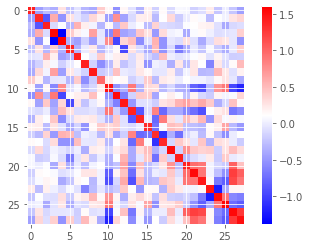

Sample Ictal and Non-Ictal Simularity Matrix for GDE
sample ictal


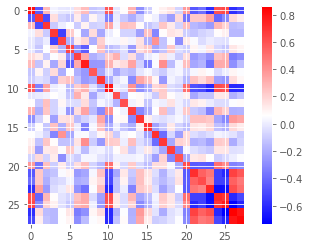

sample Non-Ictal


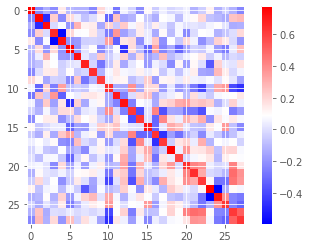

----------Training MLP-----------
0.602 ----------saved-----------
0.698 ----------saved-----------
0.725 ----------saved-----------
0.741 ----------saved-----------
0.752 ----------saved-----------
0.76 ----------saved-----------
0.769 ----------saved-----------
0.777 ----------saved-----------
0.785 ----------saved-----------
0.791 ----------saved-----------
0.798 ----------saved-----------
0.804 ----------saved-----------
0.81 ----------saved-----------
0.815 ----------saved-----------
0.818 ----------saved-----------
0.821 ----------saved-----------
0.821 ----------saved-----------
----------------------------------
0.611 ----------saved-----------
0.625 ----------saved-----------
0.646 ----------saved-----------
0.662 ----------saved-----------
0.675 ----------saved-----------
0.686 ----------saved-----------
0.695 ----------saved-----------
0.701 ----------saved-----------
0.706 ----------saved-----------
0.711 ----------saved-----------
0.716 ----------saved-----------
0.723 ---

In [59]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, create_DAD(Araw))

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.3517 F1 accuracy 0.263 Precision accuracy 0.152 Recall accuracy 0.959 AUC accuracy: 0.788
device set to cuda
threshold: 0.1  validation loss: 0.3517 F1 accuracy 0.418 Precision accuracy 0.3 Recall accuracy 0.691 AUC accuracy: 0.788
device set to cuda
threshold: 0.15  validation loss: 0.3517 F1 accuracy 0.358 Precision accuracy 0.5 Recall accuracy 0.278 AUC accuracy: 0.788
device set to cuda
threshold: 0.2  validation loss: 0.3517 F1 accuracy 0.13 Precision accuracy 0.667 Recall accuracy 0.072 AUC accuracy: 0.788
device set to cuda
threshold: 0.25  validation loss: 0.3517 F1 accuracy 0.04 Precision accuracy 0.667 Recall accuracy 0.021 AUC accuracy: 0.788
device set to cuda
threshold: 0.3  validation loss: 0.3517 F1 accuracy 0.04 Precision accuracy 1.0 Recall accuracy 0.021 AUC accuracy: 0.788
device set to cuda
threshold: 0.35  validation loss: 0.3517 F1 accuracy 0.03 Precision accuracy 1.0 Recall accuracy 0.015 AUC ac

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3474 F1 accuracy 0.394 Precision accuracy 0.273 Recall accuracy 0.706 AUC accuracy: 0.803
device set to cuda
threshold: 0.15  validation loss: 0.3474 F1 accuracy 0.469 Precision accuracy 0.637 Recall accuracy 0.371 AUC accuracy: 0.803
device set to cuda
threshold: 0.2  validation loss: 0.3474 F1 accuracy 0.17 Precision accuracy 0.655 Recall accuracy 0.098 AUC accuracy: 0.803
device set to cuda
threshold: 0.25  validation loss: 0.3474 F1 accuracy 0.04 Precision accuracy 0.667 Recall accuracy 0.021 AUC accuracy: 0.803
device set to cuda
threshold: 0.3  validation loss: 0.3474 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.803
device set to cuda
threshold: 0.35  validation loss: 0.3474 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.803
device set to cuda
threshold: 0.4  validation loss: 0.3474 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.803
device set to cuda
threshold: 0.45  validation loss: 0.3474 F

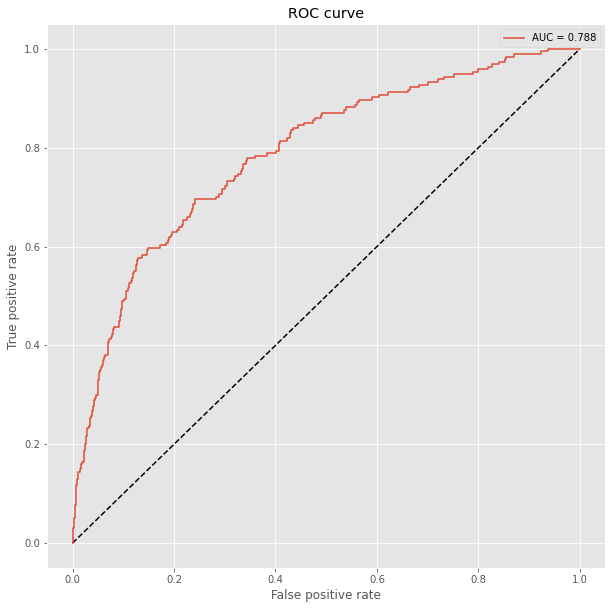

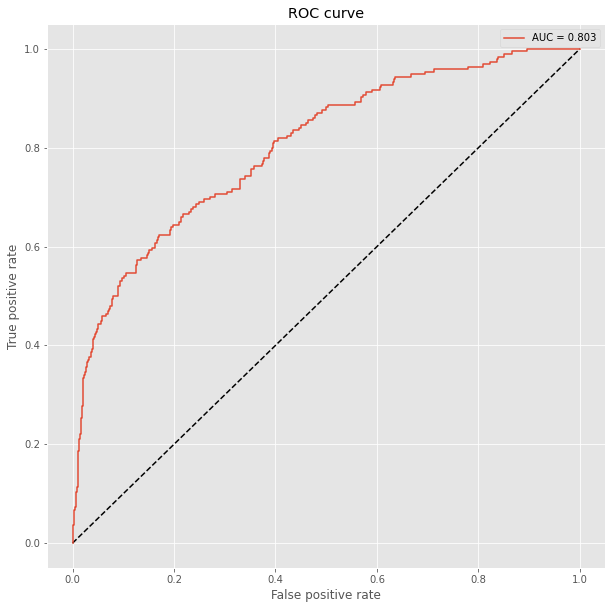

In [34]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')